### Este notebook contendrá también técnicas de EDA y preprocesado forzando valores del dataset de origen para mostrar las técnmicas de preprocesado

In [ ]:
import pandas as pd
import logging

logging.basicConfig(filename='classifier.log',level=logging.INFO, format='%(asctime)s %(message)s')
logger = logging.getLogger("Dataset_eda")


Error: Failed to connect to Jupyter notebook. 
http://localhost:8889/
Error: Invalid response: 500 Internal Server Error

 Load dataset:

In [2]:
from project.dataset_elt import dataset_extraction as ds_ext
from project.dataset_plots import generic_plots as ds_plotter
from project.dataset_EDA import eda  

dataset_location = ".\\project\\datasets\\precipitations_df.csv"
iot_client_host="industryonesait.cwbyminsait.com"
iot_client_name="predictionclient"
iot_client_token="1b5e4bf62cb94812a838e215b20cdcdd"

ds_extractor = ds_ext.Dataset_extraction(dataset_location, iot_client_host, iot_client_name, iot_client_token)

ontology = "predictionmodel"
columns_names = ['tmp0', 'tmp1', 'hPa', 'hum', 'pp']
limit_rows_number = 5000
precipitations_df = ds_extractor.load_dataset(csv_mode=True, separator=',')

precipitations_df.drop(['Unnamed: 0'], axis=1, inplace=True)
precipitations_df.iloc[5:15]


,tmp0,tmp1,hPa,hum,pp
5,9.52,6.88,1002.0,0.11,0.0
6,8.41,8.98,1079.0,0.33,0.0
7,37.01,33.32,1086.0,0.76,0.0
8,36.14,25.51,1088.0,0.08,0.0
9,14.86,14.12,930.0,0.95,1861.0
10,7.33,6.12,1023.0,0.92,2073.0
11,25.80,32.75,990.0,0.68,0.0
12,11.97,9.50,931.0,0.62,0.0
13,16.99,17.79,1050.0,0.62,0.0
14,6.29,6.55,1005.0,0.87,0.0


### provocamos outliers en tmp1

In [47]:
values_to_change = precipitations_df.iloc[8:13]['tmp1'].values
changed_values = [x*10 for x in values_to_change]
changed_values

[255.10000000000002, 141.2, 61.2, 327.5, 95.0]

In [48]:
precipitations_df.loc[8:12, 'tmp1'] = changed_values
precipitations_df.iloc[5:15]

,tmp0,tmp1,hPa,hum,pp
5,9.52,6.88,1002.0,0.11,0.0
6,8.41,8.98,1079.0,0.33,0.0
7,37.01,33.32,1086.0,0.76,0.0
8,36.14,255.10,1088.0,0.08,0.0
9,14.86,141.20,930.0,0.95,1861.0
10,7.33,61.20,1023.0,0.92,2073.0
11,25.80,327.50,990.0,0.68,0.0
12,11.97,95.00,931.0,0.62,0.0
13,16.99,17.79,1050.0,0.62,0.0
14,6.29,6.55,1005.0,0.87,0.0


### provocamos error de formato

In [49]:
values_to_change = precipitations_df.iloc[6:10]['hum'].values
changed_values = [str(x).replace('.', ',') for x in values_to_change]
changed_values

['0,33', '0,76', '0,08', '0,95']

In [50]:
precipitations_df.loc[6:9, 'hum'] = changed_values
precipitations_df.iloc[5:15]

,tmp0,tmp1,hPa,hum,pp
5,9.52,6.88,1002.0,0.11,0.0
6,8.41,8.98,1079.0,"0,33",0.0
7,37.01,33.32,1086.0,"0,76",0.0
8,36.14,255.10,1088.0,"0,08",0.0
9,14.86,141.20,930.0,"0,95",1861.0
10,7.33,61.20,1023.0,0.92,2073.0
11,25.80,327.50,990.0,0.68,0.0
12,11.97,95.00,931.0,0.62,0.0
13,16.99,17.79,1050.0,0.62,0.0
14,6.29,6.55,1005.0,0.87,0.0


### Check if numeric

In [51]:
hum_values = precipitations_df['hum']
non_numeric_hum_mask = hum_values.str.isnumeric()==False
hum_values[non_numeric_hum_mask]

6    0,33
7    0,76
8    0,08
9    0,95
Name: hum, dtype: object

### reemplazamos la coma por punto en los registros con id: 6, 7, 8, 9

In [52]:
non_numeric_indexes = hum_values[non_numeric_hum_mask].index
precipitations_df.iloc[non_numeric_indexes]

,tmp0,tmp1,hPa,hum,pp
6,8.41,8.98,1079.0,"0,33",0.0
7,37.01,33.32,1086.0,"0,76",0.0
8,36.14,255.10,1088.0,"0,08",0.0
9,14.86,141.20,930.0,"0,95",1861.0


In [53]:
precipitations_df.loc[non_numeric_indexes, 'hum'] = pd.Series([str(x).replace(',', '.') for x in precipitations_df.iloc[non_numeric_indexes]])
non_numeric_hum_mask = precipitations_df['hum'].str.isnumeric()==False
precipitations_df[non_numeric_hum_mask]

AttributeError: Can only use .str accessor with string values!

### <font color='green'> Detectamos y corregimos outliers </font>

In [15]:
from project.dataset_plots import generic_plots as ds_plotter
plotter_obj = ds_plotter.Dataset_plots(precipitations_df)

plotter_obj.make_line_plots(title='temperaturas', attributes_to_plot=['tmp1'], x_axis_label='date', y_axis_label='temperature', 
                            legend_location="top_left", background_color=None) 
                    #save_as_file=False, file_name=None)

Loading BokehJS ...

C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\bokeh\models\plots.py:756: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with the 'legend' parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


### Otra forma es mediante la caja de Box-Whisker

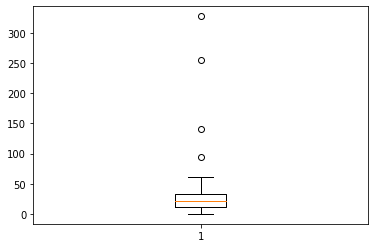

In [18]:
from matplotlib import pyplot

pyplot.boxplot(precipitations_df['tmp1'])
pyplot.show()

### Test de Tukey

In [19]:
eda_prec_df = eda.Dataset_eda(precipitations_df)

outlier_indices, samples_with_outlier_values = eda_prec_df.get_outliers_tukey_test('tmp1')

print('temperatures outlier_indices: {}'.format(outlier_indices))
print('samples with tempearures outlier values: ')
samples_with_outlier_values

temperatures outlier_indices: [8, 9, 11, 12]
samples with tempearures outlier values: 


,tmp0,tmp1,hPa,hum,pp
8,36.14,255.1,1088.0,0.08,0.0
9,14.86,141.2,930.0,0.95,1861.0
11,25.80,327.5,990.0,0.68,0.0
12,11.97,95.0,931.0,0.62,0.0


### si queremos eliminar los registros con outliers:

In [21]:
precipitations_df = precipitations_df.drop(outlier_indices)
eda_prec_df = eda.Dataset_eda(precipitations_df)
outlier_indices, samples_with_outlier_values = eda_prec_df.get_outliers_tukey_test('tmp1')
outlier_indices

[]

### provocamos valores nulos

In [272]:
pp_values_to_nan = precipitations_df.iloc[22:25]['pp'].values
pp_values_to_nan

array([0., 0., 0.])

In [273]:
import numpy as np

pp_values_to_nan = [np.nan for x in pp_values_to_nan] 
precipitations_df.loc[22:24, 'pp'] = pp_values_to_nan
precipitations_df.iloc[22:25]

,tmp0,tmp1,hPa,hum,pp
22,32.40,32.67,1010.0,0,NaN
23,20.63,17.14,913.0,0.32,NaN
24,23.23,27.44,921.0,0.58,NaN


### <font color='green'> Check valores nulos </font>

In [274]:
make_line_plots(precipitations_df.iloc[:100], 'precipitaciones', ['blue'], x_axis_label='x', y_axis_label='y', 
                    attributes_to_plot=['pp'], plot_width=1000, plot_height=400, 
                    x_axis_type=None, legend_location="top_left", background_color=None, 
                    save_as_file=False, file_name=None)

Loading BokehJS ...

In [69]:
missing_pp_values = precipitations_df.iloc[:100]['pp'].isna()
missing_pp_values[missing_pp_values==True]

22    True
23    True
24    True
Name: pp, dtype: bool

### <font color='green'> Correción missing values </font>

In [120]:
def impute_attribute(dataframe, attribute, desired_strategy):
    try:
        from sklearn.impute import SimpleImputer
        import numpy as np

        attribute_values = dataframe[attribute].values.reshape(-1, 1)
        imp = SimpleImputer(missing_values=np.nan, strategy=desired_strategy)
        imp.fit(attribute_values)
        transformed_values = imp.transform(attribute_values)
        dataframe.loc[:, attribute] = transformed_values
        
        return dataframe

    except Exception as exc:
            return exc

In [121]:
imputed_dataframe = impute_attribute(precipitations_df, 'pp', 'median')

In [123]:
missing_pp_values = imputed_dataframe['pp'].isna()
imputed_dataframe[missing_pp_values==True]

,tmp0,tmp1,hPa,hum,pp


## Exploratory Data Analysis (EDA) steps:
    - a first view on the dataframe content: length, some of the first and last rows
    - generation of a profile report in HTML format, containing exploratory analysis info  
      likeattributes correlations, descriptive statistics values, Pearson's correlation matrix, 
      outlier detections, missing values detections...
    - custom functions to get this info per atribute

In [144]:
from project.dataset_EDA import eda as ds_eda

eda_obj = ds_eda.Dataset_eda(precipitations_df)
df_length, head_df, tail_df = eda_obj.check_dataframe_content()


In [145]:
eda_obj.profile_dataframe(output_file_location_name=".\\dataset_EDA\\eda_reports\\precipitations_dataset_eda_report.html")
# Attributes discarded due to high correlation over a defined threshold: 0,9
rejected_attrs = eda_obj.get_rejected_attributes(correlation_threshold=0.9)
if rejected_attrs is not None:
    precipitations_df.drop(rejected_attrs, axis=1, inplace=True)

precipitations_df.columns


Index(['tmp0', 'tmp1', 'hPa', 'hum', 'pp'], dtype='object')

 Check for any missing values
    If there is a row with more than 50% of the attributes with missing values, drop the row.
    Otherwise, impute the missing value in that attribute.

In [146]:
row_indexes_to_delete = eda_obj.check_row_indexes_to_delete(0.5)
row_indexes_to_delete


Int64Index([], dtype='int64')

In [147]:
"""
  And now, we check for each attribute, any possible missing values
"""
from tqdm import tqdm

attributes_missing_counts_dict = {}
for attribute in tqdm(precipitations_df.columns):
  attribute_missing_sub_df = eda_obj.check_for_missing_values(attribute)
  if attribute_missing_sub_df is not None:
    attributes_missing_counts_dict[attribute] = len(attribute_missing_sub_df)  

attributes_missing_counts_dict

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11821.60it/s]


{}

## Conversion of the target variable to binary values for the binary classification:
 - pp = 0, target value = 0
 - pp > 0, target value = 1

In [3]:
from project.dataset_preprocessing import preprocessing as ds_prep
from project.modelling import binary_classifier as ds_classifier 
import numpy as np

precipitations_df['binary_pp'] = precipitations_df.pp
ds_preprocessor = ds_prep.Preprocessing(precipitations_df)
target_name = precipitations_df.columns[-1]
attributes_names = precipitations_df.columns[:-2]

precipitations_df['binary_pp'] = ds_preprocessor.binarize_target_variable(precipitations_df['binary_pp'])
precipitations_df['binary_pp'] = precipitations_df['binary_pp'].apply(lambda x: np.int(x))

precipitations_df.iloc[10:15]

,tmp0,tmp1,hPa,hum,pp,binary_pp
10,7.33,6.12,1023.0,0.92,2073.0,1
11,25.80,32.75,990.0,0.68,0.0,0
12,11.97,9.50,931.0,0.62,0.0,0
13,16.99,17.79,1050.0,0.62,0.0,0
14,6.29,6.55,1005.0,0.87,0.0,0


In [4]:
X_scaled = ds_preprocessor.standard_scaler_transformer(precipitations_df[attributes_names], attributes_names)

precipitations_df_scaled = X_scaled
precipitations_df_scaled['binary_pp'] = precipitations_df['binary_pp']
X_scaled=None
precipitations_df_scaled.head(6)

,tmp0,tmp1,hPa,hum,binary_pp
0,1.309372,2.037798,1.358912,1.484169,0
1,-1.184894,-1.132498,-1.300467,0.228533,0
2,-0.318882,-0.197877,-0.533338,0.542442,0
3,-0.454697,-0.436701,0.694067,0.368048,0
4,1.416956,0.875047,0.097412,-1.271255,0
5,-1.007877,-1.141766,-0.175345,-1.375891,0


In [5]:
ds_bin_classifier = ds_classifier.Binary_classifier(precipitations_df_scaled, attributes=attributes_names, target=target_name)


In [6]:
X_train, X_validation, y_train, y_validation = ds_bin_classifier.split_into_train_validation_sets(0.2)

## Training phase
 We decide a list of desired models to implement in the training process:
 - Dummy most-frequent classifier
 - Gaussian Naive Bayes classifier
 - Logistic regression classifier
 - Support Vector classifier
 - Multilayer Perceptron classifier

In [7]:
import sklearn
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB

GaussianNB_clf = GaussianNB()

gauss_bayes_clf = GridSearchCV(GaussianNB_clf, {'var_smoothing': [1e-09, 1e-08, 1e-10]}, cv=5, scoring=['recall', 'f1', 'roc_auc'], refit='roc_auc', return_train_score=True)
gauss_bayes_clf.fit(X_train, y_train)
gauss_model_results=pd.DataFrame(pd.DataFrame(gauss_bayes_clf.cv_results_))
gauss_bayes_clf_best_est = gauss_bayes_clf.best_estimator_
gauss_model_results['algo'] = pd.Series({})
gauss_model_results['algo'] = 'GaussianNB'

gauss_model_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,algo
0,0.002201,0.000413,0.004177,0.000405,1e-09,{'var_smoothing': 1e-09},0.825581,0.741176,0.823529,0.823529,...,0.006832,1,0.962611,0.964181,0.96076,0.965466,0.963505,0.963305,0.001577,GaussianNB
1,0.001988,0.000014,0.003796,0.000399,1e-08,{'var_smoothing': 1e-08},0.825581,0.741176,0.823529,0.823529,...,0.006832,1,0.962611,0.964181,0.96076,0.965466,0.963505,0.963305,0.001577,GaussianNB
2,0.001385,0.000479,0.003976,0.000019,1e-10,{'var_smoothing': 1e-10},0.825581,0.741176,0.823529,0.823529,...,0.006832,1,0.962611,0.964181,0.96076,0.965466,0.963505,0.963305,0.001577,GaussianNB


In [8]:
from sklearn.linear_model import LogisticRegression 
#'LogisticRegression': {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [1, 0.1, 0.01]}
Logistic_reg_clf = LogisticRegression()

log_reg_clf = GridSearchCV(Logistic_reg_clf, {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [1, 0.1, 0.01]}, cv=10, scoring=['precision', 'recall', 'roc_auc'], refit='recall', return_train_score=True)
log_reg_clf.fit(X_train, y_train)
log_reg_model_results=pd.DataFrame(pd.DataFrame(log_reg_clf.cv_results_))
log_reg_clf_best_est = log_reg_clf.best_estimator_
log_reg_model_results['algo'] = pd.Series({})
log_reg_model_results['algo'] = 'LogisticRegression'

log_reg_model_results


C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_precision,split1_test_precision,...,split3_train_roc_auc,split4_train_roc_auc,split5_train_roc_auc,split6_train_roc_auc,split7_train_roc_auc,split8_train_roc_auc,split9_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,algo
0,0.062763,0.003936,0.004941,0.004167,1,l1,liblinear,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.891304,0.913043,...,0.998371,0.998572,0.998353,0.998481,0.998364,0.998465,0.998478,0.998421,0.000079,LogisticRegression
1,0.005744,0.004280,0.003579,0.000488,1,l2,liblinear,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.909091,0.931818,...,0.998263,0.998465,0.998249,0.998332,0.998205,0.998345,0.998366,0.998293,0.000086,LogisticRegression
2,0.014459,0.001625,0.003781,0.000397,0.1,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.926829,0.928571,...,0.997941,0.998229,0.997981,0.998100,0.997881,0.998089,0.998051,0.998006,0.000110,LogisticRegression
3,0.003996,0.000021,0.003545,0.000484,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",1.000000,1.000000,...,0.996462,0.996873,0.996387,0.996496,0.996254,0.996537,0.996628,0.996498,0.000155,LogisticRegression
4,0.003891,0.000301,0.005138,0.004800,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.000000,0.000000,...,0.954537,0.955605,0.954214,0.958049,0.955529,0.954628,0.955874,0.955472,0.001238,LogisticRegression
5,0.003478,0.000504,0.003705,0.000449,0.01,l2,liblinear,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",1.000000,1.000000,...,0.983217,0.984259,0.982722,0.984196,0.982979,0.983449,0.983934,0.983512,0.000528,LogisticRegression


In [9]:
results_cv_df = pd.DataFrame({})
results_cv_df = results_cv_df.append(gauss_model_results, sort=False)
results_cv_df = results_cv_df.append(log_reg_model_results, sort=False)
results_cv_df


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,split5_test_roc_auc,split6_test_roc_auc,split7_test_roc_auc,split8_test_roc_auc,split9_test_roc_auc,split5_train_roc_auc,split6_train_roc_auc,split7_train_roc_auc,split8_train_roc_auc,split9_train_roc_auc
0,0.002201,0.000413,0.004177,0.000405,1e-09,{'var_smoothing': 1e-09},0.825581,0.741176,0.823529,0.823529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001988,0.000014,0.003796,0.000399,1e-08,{'var_smoothing': 1e-08},0.825581,0.741176,0.823529,0.823529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001385,0.000479,0.003976,0.000019,1e-10,{'var_smoothing': 1e-10},0.825581,0.741176,0.823529,0.823529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.062763,0.003936,0.004941,0.004167,NaN,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.953488,0.976744,0.976744,0.906977,...,0.998762,0.998533,0.999066,0.998066,0.998133,0.998353,0.998481,0.998364,0.998465,0.998478
1,0.005744,0.004280,0.003579,0.000488,NaN,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.930233,0.953488,0.953488,0.883721,...,0.998762,0.998066,0.998933,0.997933,0.997466,0.998249,0.998332,0.998205,0.998345,0.998366
2,0.014459,0.001625,0.003781,0.000397,NaN,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.883721,0.906977,0.883721,0.837209,...,0.998241,0.997399,0.998533,0.997999,0.997732,0.997981,0.998100,0.997881,0.998089,0.998051
3,0.003996,0.000021,0.003545,0.000484,NaN,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.744186,0.720930,0.558140,0.767442,...,0.998176,0.993664,0.997132,0.996865,0.995131,0.996387,0.996496,0.996254,0.996537,0.996628
4,0.003891,0.000301,0.005138,0.004800,NaN,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.000000,0.000000,0.000000,0.000000,...,0.965019,0.931806,0.955382,0.963152,0.952114,0.954214,0.958049,0.955529,0.954628,0.955874
5,0.003478,0.000504,0.003705,0.000449,NaN,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.023256,0.023256,0.000000,0.116279,...,0.989708,0.971922,0.983593,0.986995,0.980592,0.982722,0.984196,0.982979,0.983449,0.983934


In [10]:
results_cv_df[['params', 'mean_test_precision', 'std_test_precision', 'mean_test_recall', 'std_test_recall', 'mean_test_roc_auc', 'std_test_roc_auc']]

,params,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc
0,{'var_smoothing': 1e-09},NaN,NaN,0.791020,0.040683,0.962399,0.006832
1,{'var_smoothing': 1e-08},NaN,NaN,0.791020,0.040683,0.962399,0.006832
2,{'var_smoothing': 1e-10},NaN,NaN,0.791020,0.040683,0.962399,0.006832
0,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.918243,0.051077,0.931820,0.034150,0.998391,0.000650
1,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.936176,0.041478,0.880189,0.071757,0.998284,0.000773
2,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.948753,0.041271,0.847480,0.072108,0.998042,0.000663
3,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.989087,0.017255,0.680948,0.107304,0.996330,0.001618
4,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.000000,0.000000,0.000000,0.000000,0.955201,0.011123
5,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.500500,0.500000,0.023395,0.034595,0.982664,0.006194


### Comprobamos el mejor estimador según la métrica media en test set más alta

In [11]:
max_mean_test_recall = results_cv_df.mean_test_recall.max()
results_cv_df[results_cv_df.mean_test_recall==max_mean_test_recall]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,split5_test_roc_auc,split6_test_roc_auc,split7_test_roc_auc,split8_test_roc_auc,split9_test_roc_auc,split5_train_roc_auc,split6_train_roc_auc,split7_train_roc_auc,split8_train_roc_auc,split9_train_roc_auc
0,0.062763,0.003936,0.004941,0.004167,NaN,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.953488,0.976744,0.976744,0.906977,...,0.998762,0.998533,0.999066,0.998066,0.998133,0.998353,0.998481,0.998364,0.998465,0.998478


In [12]:
# Best params según mi dataframe
results_cv_df[results_cv_df.mean_test_recall==max_mean_test_recall].params

0    {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Name: params, dtype: object

In [13]:
# Best score según mi dataframe:
results_cv_df[results_cv_df.mean_test_recall==max_mean_test_recall].mean_test_recall

0    0.93182
Name: mean_test_recall, dtype: float64

### Comparamos con el best estimator dado por scikit

In [14]:
print('log_reg_clf.best_params_: ', log_reg_clf.best_params_)
print('log_reg_clf.best_score_: ', log_reg_clf.best_score_)

log_reg_clf.best_params_:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
log_reg_clf.best_score_:  0.9318197674418605


### Representamos la curva precision-recall; para ello, estimamos las probabilidades de predicción sobre un validation set (escogido anteriormente) 

In [15]:
selected_model = log_reg_clf.best_estimator_
y_validation_prediction_probs =  selected_model.predict_proba(X_validation)
y_validation_prediction_probs

array([[3.66304605e-01, 6.33695395e-01],
       [9.99999998e-01, 1.89317960e-09],
       [3.83354903e-02, 9.61664510e-01],
       ...,
       [1.31113018e-01, 8.68886982e-01],
       [1.00000000e+00, 6.54776198e-11],
       [9.99724770e-01, 2.75229692e-04]])

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#using probabilities only for class 1 (positive class)
precisions, recalls, thresholds = precision_recall_curve(y_validation, y_validation_prediction_probs[:, 1])
precision_recall_auc = auc(recalls, precisions)
precision_recall_auc

0.9719038113258016

In [17]:
thresholds[-10:]

array([0.99997406, 0.99998673, 0.99998767, 0.99999006, 0.99999245,
       0.99999451, 0.999998  , 0.99999873, 0.99999905, 0.9999997 ])

In [18]:
recalls[-10:]

array([0.08411215, 0.07476636, 0.06542056, 0.05607477, 0.04672897,
       0.03738318, 0.02803738, 0.01869159, 0.00934579, 0.        ])

In [19]:
precisions[-10:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
# PLot con Bokeh:
def make_line_plots_2(title, x_values, y_values, x_axis_label='x', y_axis_label='y', 
                        background_color=None, legend_location="top_left", line_color='blue',
                        width=500, height=500):
    try:
        from bokeh.plotting import figure, show, output_file
        from bokeh.models import HoverTool
        from bokeh.io import output_notebook

        output_notebook()

        p = figure(title=title, background_fill_color=background_color, plot_width=width, plot_height=height)

        p.line(x_values, y_values, line_dash=[4, 4], line_color=line_color,
                            line_width=2)

        p.y_range.start = 0
        p.legend.location = legend_location
        p.legend.background_fill_color = background_color
        p.xaxis.axis_label = x_axis_label
        p.yaxis.axis_label = y_axis_label
        p.grid.grid_line_color="white"

        p.add_tools(HoverTool())
        p.legend.click_policy="hide"

        show(p)
    except Exception as exc:
        return exc


In [22]:
make_line_plots_2('Precision-Recall curve', recalls, precisions, x_axis_label='recalls', y_axis_label='precisions', 
                 background_color=None, legend_location="top_left", line_color='blue', width=500, height=300)


Loading BokehJS ...

### bar plot

In [23]:
rain_labels = ['rain' if x==1 else 'not rain' for x in precipitations_df['binary_pp'].values]
unique_elements, counts_elements = np.unique(rain_labels, return_counts=True)
unique_elements
counts_elements

array([4467,  533], dtype=int64)

In [24]:
from bokeh.io import show, output_file
from bokeh.plotting import figure

rain_labels = ['rain' if x==1 else 'not rain' for x in precipitations_df['binary_pp'].values]
unique_elements, counts_elements = np.unique(rain_labels, return_counts=True)

p = figure(x_range=unique_elements, plot_height=250, title="Rain counts",
           toolbar_location=None, tools="")

p.vbar(x=unique_elements, top=counts_elements, width=0.5)

p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

### Y ahora probamos también la máquina vector soporte

In [31]:
from sklearn.svm import SVC

support_vector_clf = SVC()

svc_clf = GridSearchCV(support_vector_clf, {'C': [1, 0.1, 0.01], 'gamma': ['scale', 'auto'], 'class_weight': ['balanced']}, cv=5, scoring=['recall', 'f1', 'roc_auc'], refit='recall', return_train_score=True)
svc_clf.fit(X_train, y_train)
svc_model_results=pd.DataFrame(pd.DataFrame(svc_clf.cv_results_))
svc_clf_best_est = svc_clf.best_estimator_
svc_model_results['algo'] = pd.Series({})
svc_model_results['algo'] = 'SupportVectorMachine'
svc_model_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,params,split0_test_recall,split1_test_recall,...,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,algo
0,0.043401,0.003246,0.018982,0.000638,1,balanced,scale,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",1.0,0.976471,...,0.000588,2,0.997709,0.997757,0.997972,0.998267,0.998065,0.997954,0.000205,SupportVectorMachine
1,0.041087,0.001573,0.018546,0.000495,1,balanced,auto,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",1.0,0.976471,...,0.000584,1,0.997707,0.997751,0.997968,0.998264,0.998064,0.997951,0.000205,SupportVectorMachine
2,0.068606,0.001720,0.032977,0.000837,0.1,balanced,scale,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",1.0,1.000000,...,0.001669,4,0.994361,0.993783,0.994695,0.995026,0.994733,0.994520,0.000424,SupportVectorMachine
3,0.068685,0.001007,0.032916,0.000623,0.1,balanced,auto,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",1.0,1.000000,...,0.001660,3,0.994359,0.993780,0.994693,0.995017,0.994738,0.994517,0.000424,SupportVectorMachine
4,0.149403,0.002226,0.064958,0.000670,0.01,balanced,scale,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",1.0,1.000000,...,0.004338,5,0.978956,0.981303,0.979993,0.981764,0.980692,0.980542,0.000991,SupportVectorMachine
5,0.146649,0.001842,0.064982,0.000999,0.01,balanced,auto,"{'C': 0.01, 'class_weight': 'balanced', 'gamma...",1.0,1.000000,...,0.004340,6,0.978948,0.981303,0.979915,0.981734,0.980679,0.980516,0.000995,SupportVectorMachine


In [32]:
results_cv_df = results_cv_df.append(svc_model_results)
results_cv_df

C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,algo,mean_fit_time,mean_score_time,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_train_f1,mean_train_precision,mean_train_recall,...,std_fit_time,std_score_time,std_test_f1,std_test_precision,std_test_recall,std_test_roc_auc,std_train_f1,std_train_precision,std_train_recall,std_train_roc_auc
0,GaussianNB,0.002201,0.004177,0.702095,NaN,0.791020,0.962399,0.712391,NaN,0.817483,...,0.000413,0.000405,0.043353,NaN,0.040683,0.006832,0.011266,NaN,0.011121,0.001577
1,GaussianNB,0.001988,0.003796,0.702095,NaN,0.791020,0.962399,0.712391,NaN,0.817483,...,0.000014,0.000399,0.043353,NaN,0.040683,0.006832,0.011266,NaN,0.011121,0.001577
2,GaussianNB,0.001385,0.003976,0.702095,NaN,0.791020,0.962399,0.712391,NaN,0.817483,...,0.000479,0.000019,0.043353,NaN,0.040683,0.006832,0.011266,NaN,0.011121,0.001577
0,LogisticRegression,0.062763,0.004941,NaN,0.918243,0.931820,0.998391,NaN,0.920593,0.940008,...,0.003936,0.004167,NaN,0.051077,0.034150,0.000650,NaN,0.005515,0.004833,0.000079
1,LogisticRegression,0.005744,0.003579,NaN,0.936176,0.880189,0.998284,NaN,0.942884,0.894622,...,0.004280,0.000488,NaN,0.041478,0.071757,0.000773,NaN,0.006137,0.007369,0.000086
2,LogisticRegression,0.014459,0.003781,NaN,0.948753,0.847480,0.998042,NaN,0.952242,0.852370,...,0.001625,0.000397,NaN,0.041271,0.072108,0.000663,NaN,0.006161,0.009904,0.000110
3,LogisticRegression,0.003996,0.003545,NaN,0.989087,0.680948,0.996330,NaN,0.993866,0.669535,...,0.000021,0.000484,NaN,0.017255,0.107304,0.001618,NaN,0.003333,0.015786,0.000155
4,LogisticRegression,0.003891,0.005138,NaN,0.000000,0.000000,0.955201,NaN,0.000000,0.000000,...,0.000301,0.004800,NaN,0.000000,0.000000,0.011123,NaN,0.000000,0.000000,0.001238
5,LogisticRegression,0.003478,0.003705,NaN,0.500500,0.023395,0.982664,NaN,1.000000,0.026601,...,0.000504,0.000449,NaN,0.500000,0.034595,0.006194,NaN,0.000000,0.005796,0.000528
0,SupportVectorMachine,0.044168,0.018586,0.793543,NaN,0.995294,0.996914,0.800584,NaN,1.000000,...,0.003075,0.000481,0.016390,NaN,0.009412,0.000588,0.004061,NaN,0.000000,0.000205


In [33]:
max_mean_test_recall = results_cv_df.mean_test_recall.max()
results_cv_df[results_cv_df.mean_test_recall==max_mean_test_recall]


,algo,mean_fit_time,mean_score_time,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_roc_auc,mean_train_f1,mean_train_precision,mean_train_recall,...,std_fit_time,std_score_time,std_test_f1,std_test_precision,std_test_recall,std_test_roc_auc,std_train_f1,std_train_precision,std_train_recall,std_train_roc_auc
2,SupportVectorMachine,0.067983,0.032340,0.669159,NaN,1.0,0.993347,0.671012,NaN,1.0,...,0.000747,0.000494,0.036321,NaN,0.0,0.001669,0.003206,NaN,0.0,0.000424
3,SupportVectorMachine,0.068201,0.032349,0.668233,NaN,1.0,0.993354,0.671012,NaN,1.0,...,0.000793,0.000490,0.037349,NaN,0.0,0.001660,0.003206,NaN,0.0,0.000424
4,SupportVectorMachine,0.146384,0.064649,0.519065,NaN,1.0,0.979321,0.517179,NaN,1.0,...,0.002036,0.000410,0.016161,NaN,0.0,0.004338,0.004040,NaN,0.0,0.000991
5,SupportVectorMachine,0.146193,0.064639,0.518736,NaN,1.0,0.979295,0.517100,NaN,1.0,...,0.002862,0.000750,0.015959,NaN,0.0,0.004340,0.004022,NaN,0.0,0.000995
2,SupportVectorMachine,0.068606,0.032977,0.669159,NaN,1.0,0.993347,0.671012,NaN,1.0,...,0.001720,0.000837,0.036321,NaN,0.0,0.001669,0.003206,NaN,0.0,0.000424
3,SupportVectorMachine,0.068685,0.032916,0.668233,NaN,1.0,0.993354,0.671012,NaN,1.0,...,0.001007,0.000623,0.037349,NaN,0.0,0.001660,0.003206,NaN,0.0,0.000424
4,SupportVectorMachine,0.149403,0.064958,0.519065,NaN,1.0,0.979321,0.517179,NaN,1.0,...,0.002226,0.000670,0.016161,NaN,0.0,0.004338,0.004040,NaN,0.0,0.000991
5,SupportVectorMachine,0.146649,0.064982,0.518736,NaN,1.0,0.979295,0.517100,NaN,1.0,...,0.001842,0.000999,0.015959,NaN,0.0,0.004340,0.004022,NaN,0.0,0.000995


In [41]:
# Best params según mi dataframe
results_cv_df[results_cv_df.mean_test_recall==max_mean_test_recall].params

2    {'C': 0.1, 'class_weight': 'balanced', 'gamma'...
3    {'C': 0.1, 'class_weight': 'balanced', 'gamma'...
4    {'C': 0.01, 'class_weight': 'balanced', 'gamma...
5    {'C': 0.01, 'class_weight': 'balanced', 'gamma...
2    {'C': 0.1, 'class_weight': 'balanced', 'gamma'...
3    {'C': 0.1, 'class_weight': 'balanced', 'gamma'...
4    {'C': 0.01, 'class_weight': 'balanced', 'gamma...
5    {'C': 0.01, 'class_weight': 'balanced', 'gamma...
Name: params, dtype: object

In [35]:
print('svc_clf.best_params_: ', svc_clf.best_params_)
print('svc_clf.best_score_: ', svc_clf.best_score_)

svc_clf.best_params_:  {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale'}
svc_clf.best_score_:  1.0


In [42]:
#Logistic regression grid params
results_cv_df[['algo', 'param_solver', 'param_penalty', 'param_C']][results_cv_df.algo=='LogisticRegression']


,algo,param_solver,param_penalty,param_C
0,LogisticRegression,liblinear,l1,1
1,LogisticRegression,liblinear,l2,1
2,LogisticRegression,liblinear,l1,0.1
3,LogisticRegression,liblinear,l2,0.1
4,LogisticRegression,liblinear,l1,0.01
5,LogisticRegression,liblinear,l2,0.01


In [43]:
#SVC grid params
results_cv_df[['algo', 'param_C', 'param_class_weight', 'param_gamma']][results_cv_df.algo=='SupportVectorMachine']

,algo,param_C,param_class_weight,param_gamma
0,SupportVectorMachine,1,balanced,scale
1,SupportVectorMachine,1,balanced,auto
2,SupportVectorMachine,0.1,balanced,scale
3,SupportVectorMachine,0.1,balanced,auto
4,SupportVectorMachine,0.01,balanced,scale
5,SupportVectorMachine,0.01,balanced,auto
0,SupportVectorMachine,1,balanced,scale
1,SupportVectorMachine,1,balanced,auto
2,SupportVectorMachine,0.1,balanced,scale
3,SupportVectorMachine,0.1,balanced,auto


In [45]:
results_cv_df_2 = pd.DataFrame({})
results_cv_df_2 = results_cv_df_2.append(log_reg_model_results)
results_cv_df_2 = results_cv_df_2.append(svc_model_results)
results_cv_df_2[['algo', 'param_solver', 'param_penalty', 'param_C', 'param_class_weight', 'param_gamma', 'mean_test_roc_auc', 'mean_test_recall']]

,algo,param_solver,param_penalty,param_C,param_class_weight,param_gamma,mean_test_roc_auc,mean_test_recall
0,LogisticRegression,liblinear,l1,1,NaN,NaN,0.998391,0.931820
1,LogisticRegression,liblinear,l2,1,NaN,NaN,0.998284,0.880189
2,LogisticRegression,liblinear,l1,0.1,NaN,NaN,0.998042,0.847480
3,LogisticRegression,liblinear,l2,0.1,NaN,NaN,0.996330,0.680948
4,LogisticRegression,liblinear,l1,0.01,NaN,NaN,0.955201,0.000000
5,LogisticRegression,liblinear,l2,0.01,NaN,NaN,0.982664,0.023395
0,SupportVectorMachine,NaN,NaN,1,balanced,scale,0.996914,0.995294
1,SupportVectorMachine,NaN,NaN,1,balanced,auto,0.996918,0.995294
2,SupportVectorMachine,NaN,NaN,0.1,balanced,scale,0.993347,1.000000
3,SupportVectorMachine,NaN,NaN,0.1,balanced,auto,0.993354,1.000000


In [23]:
results_cv_df_2.columns

Index(['algo', 'mean_fit_time', 'mean_score_time', 'mean_test_f1',
       'mean_test_recall', 'mean_test_roc_auc', 'mean_train_f1',
       'mean_train_recall', 'mean_train_roc_auc', 'param_C',
       'param_class_weight', 'param_gamma', 'param_penalty', 'param_solver',
       'params', 'rank_test_f1', 'rank_test_recall', 'rank_test_roc_auc',
       'split0_test_f1', 'split0_test_recall', 'split0_test_roc_auc',
       'split0_train_f1', 'split0_train_recall', 'split0_train_roc_auc',
       'split1_test_f1', 'split1_test_recall', 'split1_test_roc_auc',
       'split1_train_f1', 'split1_train_recall', 'split1_train_roc_auc',
       'split2_test_f1', 'split2_test_recall', 'split2_test_roc_auc',
       'split2_train_f1', 'split2_train_recall', 'split2_train_roc_auc',
       'split3_test_f1', 'split3_test_recall', 'split3_test_roc_auc',
       'split3_train_f1', 'split3_train_recall', 'split3_train_roc_auc',
       'split4_test_f1', 'split4_test_recall', 'split4_test_roc_auc',
       'split4

## Plot learning curves
### Fuente: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve as learning_c
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
svc_estimator = SVC(C=1, class_weight='balanced', gamma='scale')
train_sizes=[100, 400, 900, 1500, 2000, 2600, 3000]

train_sizes, train_scores, validation_scores = learning_c(estimator=svc_estimator, X=X_train, y=y_train, train_sizes=train_sizes, 
                                                              cv=cv, scoring='roc_auc')



(0, 40)

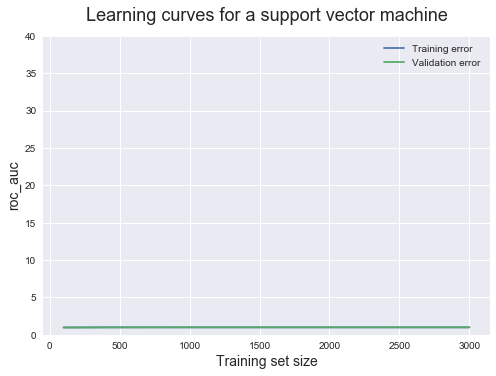

In [52]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training error')
plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Validation error')
plt.ylabel('roc_auc', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a support vector machine', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

In [53]:
train_scores

array([[0.98255814, 0.99418605, 0.98674242, 0.98947368, 1.        ],
       [0.99489275, 0.9956603 , 0.99560002, 0.99545827, 0.99717514],
       [0.99607715, 0.9967655 , 0.99802017, 0.99707819, 0.9968875 ],
       [0.99821201, 0.99772225, 0.99732038, 0.99782509, 0.99778104],
       [0.99780682, 0.99804951, 0.9979381 , 0.99760038, 0.99698725],
       [0.99804497, 0.99787452, 0.9980639 , 0.99772329, 0.99755078],
       [0.99796314, 0.99779436, 0.99815805, 0.9978978 , 0.99793231]])

### Y ahora hiperparametrización bayesiana

In [48]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2)
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # something
    model.set_params(**params)
    # calculate 5-fold cross validation
    result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
    # calculate the mean of the scores
    estimate = mean(result)
    return 1.0 - estimate
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:

In [49]:
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

izer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warning

In [61]:
from sklearn.linear_model import LogisticRegression 
from skopt.space import Real, Integer, StringEncoder

model = LogisticRegression()
# define the space of hyperparameters to search
search_space = [Real(0.01, 1.0, name='C')]
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # something
    model.set_params(**params)
    # calculate 5-fold cross validation
    result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
    # calculate the mean of the scores
    estimate = mean(result)
    return 1.0 - estimate
# perform optimization
result = gp_minimize(evaluate_model, search_space)



ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [60]:
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: C=%d' % (result.x[0]))

Best Accuracy: 0.946
Best Parameters: C=0
